# Combining sources
This document combines all relevant sources into two datasets:
- daily downloads across all shows
- episodic totals, tagged by show

Sources:
- [x] Legacy LibSyn
- [x] Legacy HIO Sounder.fm
- [x] Simplecast HIO
- [x] Simplecast TBP
- [ ] ~~Legacy SoundCloud~~
- [ ] ~~Spotify~~ only 1k (+1k from old) streams for HIO
- [x] YouTube
- [ ] ~~TBP Patreon~~ not significant numbers (FOR NOW)

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as plt
plt.style.use('ggplot')
import datetime as dt
import plotly.express as px

## YouTube

In [20]:
tbp_youtube_daily = pd.read_csv("raw_data/youtube/tbp/Totals.csv")
tbp_youtube_daily.rename(columns={"Date":"date","Views":"downloads"}, inplace=True)
tbp_youtube_daily['date'] = pd.to_datetime(tbp_youtube_daily['date'], infer_datetime_format=True)

hio_youtube_daily = pd.read_csv("raw_data/youtube/hio/Totals.csv")
hio_youtube_daily.rename(columns={"Date":"date","Views":"downloads"}, inplace=True)
hio_youtube_daily['date'] = pd.to_datetime(hio_youtube_daily['date'], infer_datetime_format=True)

In [11]:
tbp_youtube_daily

,date,downloads
0,2015-06-11,0
1,2015-06-12,0
2,2015-06-13,0
3,2015-06-14,0
4,2015-06-15,0
...,...,...
2786,2023-01-26,5
2787,2023-01-27,2
2788,2023-01-28,2
2789,2023-01-29,0


## Simplecast (Both HIO and TBP)

The timeline ranges from 2019-02-XX - Current

for details on data files, review the "Exploring_Simplecast.ipynb" file

So far, we have not created proper data for the daily stats. They need to be pulled from episodic data and tallied, which requires quite a bit of work. 

In [2]:
hio_simplecast_episodic = pd.read_feather("hio_episodic_downloads.feather")
hio_simplecast_episodic = hio_simplecast_episodic[['title', 'total_downloads', 'published_at']].copy()
hio_simplecast_episodic.rename(columns={"total_downloads":"downloads", 'published_at':'date'}, inplace=True)
tbp_simplecast_episodic = pd.read_feather("tbp_episodic_downloads.feather")
tbp_simplecast_episodic = tbp_simplecast_episodic[['title', 'total_downloads', 'published_at']].copy()
tbp_simplecast_episodic.rename(columns={"total_downloads":"downloads", 'published_at':'date'}, inplace=True)
simplecast_totals = pd.read_feather("total_podcast_downloads.feather")
tbp_simplecast_daily = pd.read_csv("raw_data/simplecast/podcast_downloads_The-Bitcoin-Podcast.csv")
tbp_simplecast_daily.rename(columns={"downloads_total":"downloads", "interval":"date"}, inplace=True)
tbp_simplecast_daily['date'] = pd.to_datetime(tbp_simplecast_daily['date'], infer_datetime_format=True)

## Legacy Libsyn

The timeline ranges from 2015-06-15 - 2019-02-17

for details on data files, review the "Exploring-downloads.ipynb" file

In [3]:
tbp_libsyn_daily = pd.read_csv("raw_data/daily-totals_2019-02-17.csv")
tbp_libsyn_daily.rename(columns = {"total_downloads":"downloads"}, inplace=True)
tbp_libsyn_daily['date'] = pd.to_datetime(tbp_libsyn_daily['date'], infer_datetime_format=True)
tbp_libsyn_episodic = pd.read_csv("dash_app/episode_data.csv")
tbp_libsyn_episodic.rename(columns={"release_date":"date"}, inplace=True)
tbp_libsyn_episodic = tbp_libsyn_episodic[['title', 'date', 'downloads']].copy()

## Legacy Sounder.fm

In [4]:
hio_sounder_episodic = pd.read_csv("raw_data/hio_sounder/episodes_summary.csv")
hio_sounder_episodic = hio_sounder_episodic[['episode_title','episode_release_date','streams_all_time']]
hio_sounder_episodic.rename(columns={"episode_title":"title", "episode_release_date":"date", "streams_all_time":"downloads"}, inplace=True)
hio_sounder_daily = pd.read_csv("raw_data/hio_sounder/overview.csv")
hio_sounder_daily.rename(columns={"name":"date", "streams":"downloads"}, inplace=True)
hio_sounder_daily['date'] = pd.to_datetime(hio_sounder_daily['date'], infer_datetime_format=True)

## Combining sources

## Daily Downloads

In [21]:
# df_daily = pd.concat([tbp_libsyn_daily, tbp_simplecast_daily], ignore_index=True)
df_daily = pd.concat([tbp_libsyn_daily, tbp_simplecast_daily, hio_sounder_daily, tbp_youtube_daily, hio_youtube_daily], ignore_index=True)
df_daily = df_daily.groupby([df_daily['date'].dt.date]).sum()
df_daily = df_daily[['downloads']]
df_daily.index = pd.to_datetime(df_daily.index)
df_monthly = df_daily.groupby(pd.Grouper(freq='M')).sum()

/tmp/ipykernel_3358/2261377421.py:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



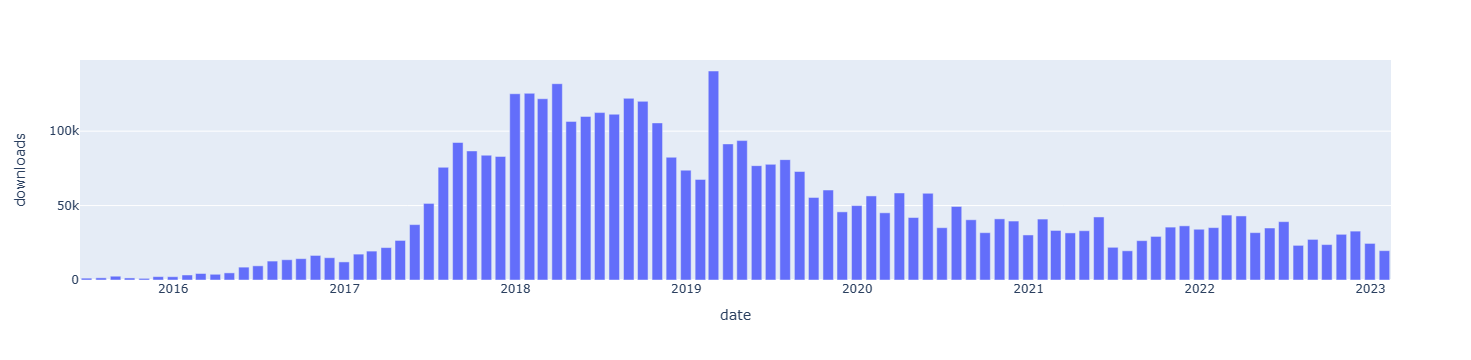

In [22]:
fig = px.bar(df_monthly, y="downloads")
fig.show()

In [23]:
df_daily.downloads.sum()

4410769.0

## Episodic Downloads

In [7]:
df_episodic = tbp_simplecast_episodic.merge(tbp_libsyn_episodic, how='left', on='title').sort_values(by='date_x')
df_episodic.downloads_y.fillna(0, inplace=True)
df_episodic.downloads_x.fillna(0, inplace=True)
df_episodic['downloads'] = df_episodic['downloads_x'] + df_episodic['downloads_y']
df_episodic['date'] = pd.to_datetime(df_episodic['date_x'], infer_datetime_format=True)

In [19]:
df_episodic.downloads.sum()

4230676.0

In [42]:
len(df_episodic)

1011

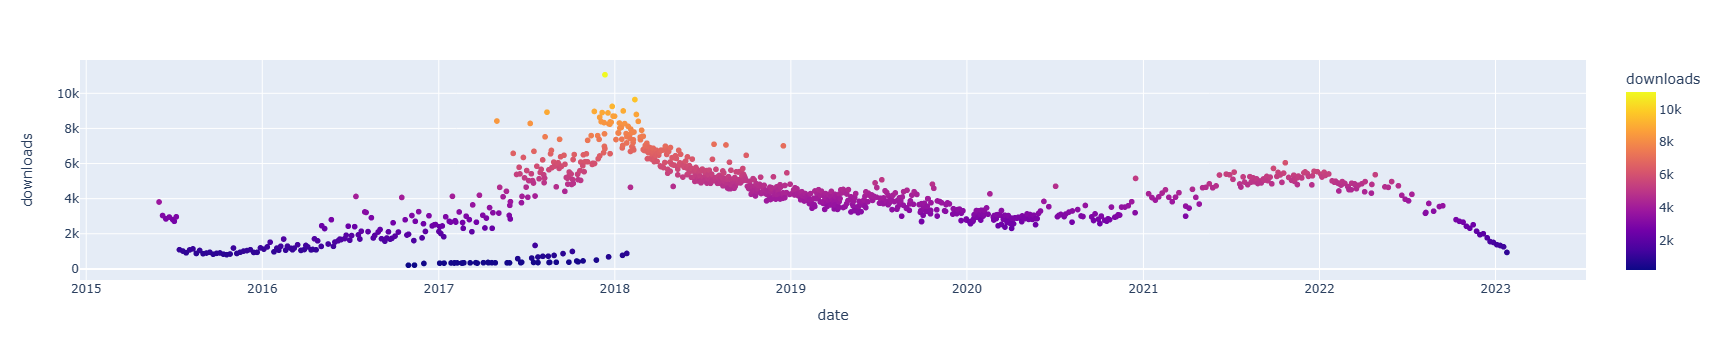

In [22]:
fig = px.scatter(df_episodic, x="date", y="downloads", color='downloads', hover_name='title')
fig.show()

In [44]:
df_episodic

,title,downloads_x,date_x,date_y,downloads_y,downloads,date
1010,Episode #1 - Introduction,376,2015-06-01T00:34:44Z,2015-06-01,3434.0,3810.0,2015-06-01 00:34:44+00:00
1009,TBP02 - Holding Up the Sky,301,2015-06-08T08:00:00Z,2015-06-07,2739.0,3040.0,2015-06-08 08:00:00+00:00
1008,TBP03 - Bridging the Gender Gap,283,2015-06-15T07:00:00Z,2015-06-15,2562.0,2845.0,2015-06-15 07:00:00+00:00
1007,TBP04 - Change Jar 2.0,280,2015-06-22T06:30:00Z,2015-06-20,2673.0,2953.0,2015-06-22 06:30:00+00:00
1006,TBP05 - The World's Strongest,263,2015-06-29T06:30:00Z,2015-06-28,2547.0,2810.0,2015-06-29 06:30:00+00:00
...,...,...,...,...,...,...,...
4,Hashing It Out-Application Infrastructure Pt. 1,1505,2022-12-27T17:00:00Z,NaN,0.0,1505.0,2022-12-27 17:00:00+00:00
3,Hashing It Out-Flash Hash: 12/05/2022,1378,2023-01-03T17:00:00Z,NaN,0.0,1378.0,2023-01-03 17:00:00+00:00
2,Hashing It Out-Application Infrastructure Pt. 2,1333,2023-01-10T17:00:00Z,NaN,0.0,1333.0,2023-01-10 17:00:00+00:00
1,Hashing It Out Personals: Dee Ferguson,1259,2023-01-17T17:00:00Z,NaN,0.0,1259.0,2023-01-17 17:00:00+00:00
